# ground-segmentation

Learning a deep neural network for ground segmentation.

## Preprocessing

### Download dataset

In [1]:
import os
import zipfile
from google_drive_downloader import GoogleDriveDownloader as gdd

DATASET_ZIPFILE = './cmu_corridor_dataset.zip'
OUTPUT_DIR = './dataset'

# Download dataset from google drive
if not os.path.exists(DATASET_ZIPFILE):
    gdd.download_file_from_google_drive(file_id='16yHVv2HIV2pqJj-Z1k8gRSb31enJeMdm',
                                        dest_path=DATASET_ZIPFILE,
                                        unzip=False)

# Uncompressed dataset
fz = zipfile.ZipFile(DATASET_ZIPFILE, 'r')
for file in fz.namelist():
    fz.extract(file, OUTPUT_DIR)

### Load dataset

In [1]:
from path import Path
import numpy as np
import scipy.io
from PIL import Image
import glob
from tqdm import tqdm_notebook, tnrange

DATASET_PATH = Path('./dataset')

# Load images
image_files = glob.glob(DATASET_PATH / 'raw_image/*.png')
image_files = sorted(image_files)
images = []
for image_file in tqdm_notebook(image_files, total=len(image_files), desc="Loading images"):
    image = np.array(Image.open(image_file).convert('L'))
    image = image / 255.0 # Normalization
    images.append(image)
images = np.array(images)

# Load labels
label_files = glob.glob(DATASET_PATH / 'ground_truth/*bw.png')
label_files = sorted(label_files)
labels = []
for label_file in tqdm_notebook(label_files, total=len(label_files), desc="Loading labels"):
    label = np.array(Image.open(label_file))
    label = label / 255.0 # Normalization
    labels.append(label)
labels = np.array(labels)

assert len(images) == len(labels)

# Load split mat
split_mat = scipy.io.loadmat(DATASET_PATH / 'train_test_split.mat')
train_index = split_mat['train_index'].ravel()
test_index = split_mat['test_index'].ravel()

### Insight dataset

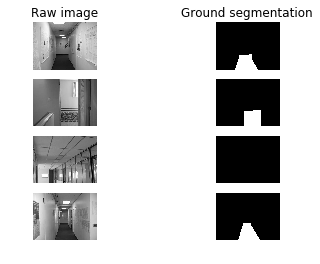

In [3]:
from matplotlib import pyplot as plt
#plt.rcParams['figure.figsize'] = [5, 8]

def plot_image(ax, img, title):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(img, cmap='gray')
    
def plot_label(ax, label, title):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(label, cmap='gray')
    
NUM_PLOTTING = 4

fig = plt.figure("Insight dataset")

for index in range(NUM_PLOTTING):
    image, label = images[index], labels[index]
    image_title = '' if index != 0 else 'Raw image'
    label_title = '' if index != 0 else 'Ground segmentation'

    ax = fig.add_subplot(NUM_PLOTTING, 2, index*2 + 1)
    plot_image(ax, image, title=image_title)
    ax = fig.add_subplot(NUM_PLOTTING, 2, index*2 + 2)
    plot_label(ax, label, title=label_title)

plt.show()

### Split dataset

In [4]:
train_index, test_index = sorted(train_index), sorted(test_index)

# Expand one dim as input is gray
extended_images = np.expand_dims(images, -1)
extended_labels = np.expand_dims(labels, -1)

X_train, y_train = extended_images[train_index], extended_labels[train_index]
X_test, y_test = extended_images[test_index], extended_labels[test_index]

## Define Model

### unet

In [5]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose, concatenate

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),\
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),\
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters*8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters*4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs], name='unet')
    return model

In [6]:
img_height, img_width = images.shape[1], images.shape[2]

In [16]:
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam, SGD

input_img = Input((img_height, img_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 240, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 240, 320, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 240, 320, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 240, 320, 16) 0           batch_normalization_19[0][0]     
_______________________________________________________________________________________________

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('models/model-gs-unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir='.logs')
]

In [19]:
results = model.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test))

Train on 725 samples, validate on 242 samples
Epoch 1/50
725/725 [==============================] - 12s 17ms/sample - loss: 0.6066 - accuracy: 0.7075 - val_loss: 0.6066 - val_accuracy: 0.8485
Epoch 2/50
725/725 [==============================] - 10s 14ms/sample - loss: 0.3856 - accuracy: 0.8889 - val_loss: 0.4420 - val_accuracy: 0.8480
Epoch 3/50
725/725 [==============================] - 10s 14ms/sample - loss: 0.3172 - accuracy: 0.9072 - val_loss: 0.3637 - val_accuracy: 0.8711
Epoch 4/50
725/725 [==============================] - 10s 14ms/sample - loss: 0.2809 - accuracy: 0.9114 - val_loss: 0.3224 - val_accuracy: 0.8761
Epoch 5/50
725/725 [==============================] - 10s 14ms/sample - loss: 0.2439 - accuracy: 0.9212 - val_loss: 0.3017 - val_accuracy: 0.8844
Epoch 6/50
725/725 [==============================] - 10s 13ms/sample - loss: 0.2139 - accuracy: 0.9295 - val_loss: 0.2564 - val_accuracy: 0.9012
Epoch 7/50
725/725 [==============================] - 10s 13ms/sample - loss: 

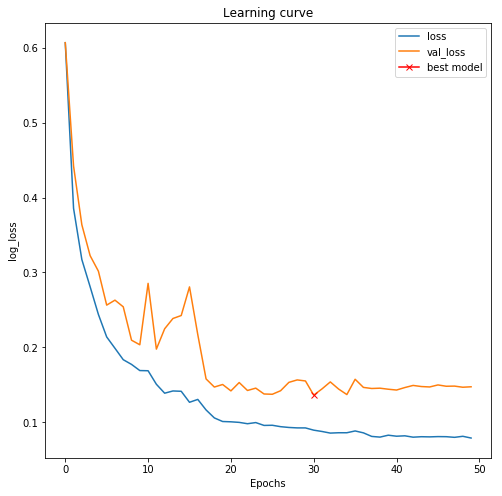

In [21]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();